# Predict COVID-19 Growth in Illinois Using a Generalized Logistic Growth Model

**Author: Ming-Sen Wang, Economist/Data Scientist**

This "shelter-in-place" project aims at developing a simple structural model to project the trajectory of the COVID-19 confirmed cases in Illinois and, hence, to assess at which stage of the epidemic is for Illnois.

The model calibrates a Generalized Logistic Growth Model to fit the data extracted from GitHub of New Times.  From the time series data, the model structurally describes how many people an infected person can potentially encounter and among those how likely one can be infected.  The model fits the data very well with the R-squared of 99%.

The model assumes that there is no interstate movement by fixing Illinois's population at 12.74 million and that the growth slows down as the number of infected increases.

## Data Preparation

State-level data are extracted from GitHub of New York Times.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import datetime as dt

In [0]:
init0 = 10

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Data/covid-19-data/us-states.csv')

In [0]:
ildata = data.loc[data['state'] == "Illinois", :].loc[data['cases'] >= init0, :]
ildata['days'] = range(ildata.shape[0])

# The Model

The model assumes that an infected is expected to encounter $r$ people by many means -- such as walking near one person within 1 meter, talking to a person, touching a handrail that 20 others touch in an hour, etc. -- throughout a day.  Among those encountered, a proportion $P$ of them would be infected and bcomes new cases.

Denote the total confirmed cases at day $t$ as $C(t)$; expected number of encounters of someone infected as $r$; the probability of an encounter contracting the virus as $P$.

Then on a given day $t$, the number of new cases is $r \cdot P \cdot C(t)$.  The total confirmed cases on the next day will be $C(t+1)  = C(t) + r \cdot P \cdot C(t)$.

Assume the probability of contraction decays as the number of confirmed cases increases: $P = 1 - \left(\frac{C(t)}{K}\right)^\alpha$, where $K = \kappa \cdot \text{Population}$.  $\alpha$ is the tuning parameter that controls the rate of decay as a function of the number of current confirmed cases.

The model is calibrated by minimizing the mean squared error.

In [0]:
from scipy.stats import beta
from scipy import optimize

def logistic_growth(init0, pop, theta, N):
  gamma = theta[0]
  kappa = theta[1]
  alpha = theta[2]

  y_pred = []
  y_now = init0
  for i in range(N):
    y_next = (1 + gamma * (1 - (y_now/(kappa * pop))**alpha)) * y_now
    y_now = y_next
    y_pred.append(y_next)

  return y_pred

def value_func(y, init0, pop, theta):
    N = len(y)
    y_pred = logistic_growth(init0, pop, theta, N)
    val = np.sqrt(np.mean([(a - b) **2 for a, b in zip(y_pred, y)]))
    return val

## Illinois Data

In [7]:
y = ildata.loc[:,'cases'] 
fit = optimize.minimize(
    fun = lambda theta: value_func(y/10000, init0/10000, 1274, theta),
    x0 = [500/10000, 0.04, 1], 
    method='SLSQP', 
    bounds= ((0, np.inf), (0, 1), (0, 1)), 
    tol = 1E-12,
    options={'maxiter': 1000}
    )

print(fit)
pred_il = [ildata['cases'].tolist()[-1]] + [x * 10000 for x in logistic_growth(ildata['cases'].tolist()[-1]/10000, 1274, fit['x'], 30)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


     fun: 0.007130715671418872
     jac: array([-8.35041283e-06, -6.37251418e-04, -7.17124203e-06])
 message: 'Optimization terminated successfully.'
    nfev: 668
     nit: 124
    njev: 121
  status: 0
 success: True
       x: array([0.48690292, 0.00145199, 0.31265018])


## Model Assessment

Using data as of March 31, the model estimates imply:

$C(t + 1) = C(t) + 4869 \cdot \left(1 - \left(\frac{C(t)}{0.1\% \cdot \text{Illinois Pop.}} \right)^{0.31} \right)$

The root mean squared error is 71 cases, which is equivalent to an R-squared of 0.99.  Overall, the model fits the data well.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 <a list of 23 Text major ticklabel objects>)

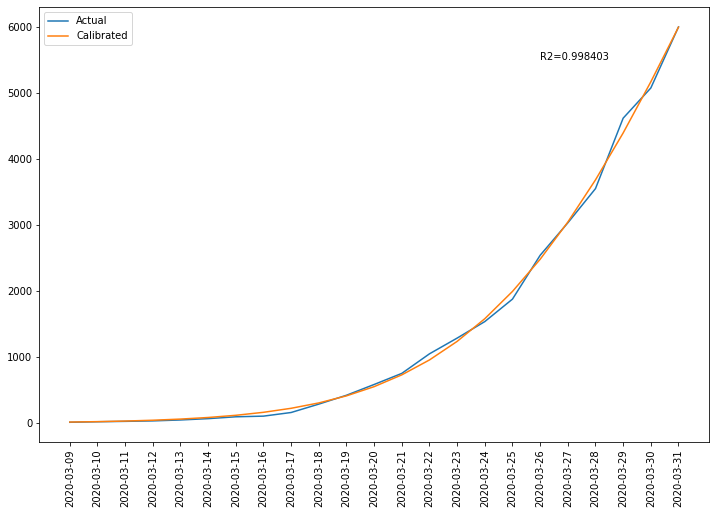

In [8]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(1, 1, 1)
y_fit = [x * 10000 for x in logistic_growth(init0/10000, 1274, fit['x'], len(ildata['cases']))]
y_val = ildata['cases']

r2 = 1 - np.sum((y_val - y_fit)**2)/np.sum((y_val - np.mean(y_val))**2)

ax.plot(ildata['date'], y_val, label = "Actual")
ax.plot(ildata['date'], y_fit, label = 'Calibrated')

ax.text('2020-03-26', 5500, 'R2=%f'%r2)

ax.legend(loc='best')

plt.xticks(rotation = 90)

## Results Summary

If the model is correctly specified, we should see the epidemic to hit the inflection point in the week of 4/1 and expect the total number of cases to reach the peak at 18,000 cases at the end of April.

In [0]:
datemin = np.datetime64(ildata['date'].tolist()[0])
datemax = np.datetime64(ildata['date'].tolist()[-1])

date_hist = [datemin + np.timedelta64(x, 'D') for x in range(ildata.shape[0])]
date_pred = [datemax] + [datemax + np.timedelta64(x, 'D') for x in range(1, 31)]

In [0]:
all_cases = ildata['cases'].tolist() + pred_il
all_dates = date_hist[1:] + date_pred

(array([737492., 737499., 737506., 737516., 737523., 737530., 737537.,
        737546.]), <a list of 8 Text major ticklabel objects>)

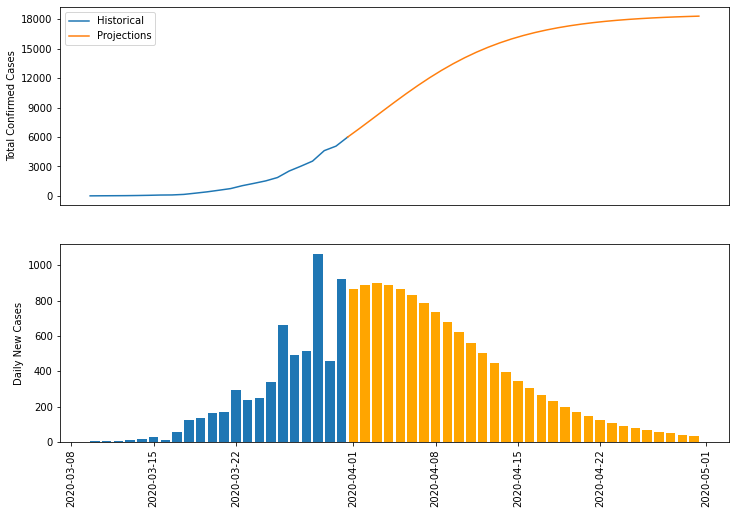

In [11]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(date_hist, ildata['cases'].tolist(), label = 'Historical')
ax1.plot(date_pred, pred_il, label = 'Projections')
ax1.set_xticks([])
ax1.set_yticks(range(0, 21000, 3000))
ax1.set_ylabel('Total Confirmed Cases')
ax1.legend(loc = 'best')

ax2.bar(date_hist[1:], np.diff(ildata['cases']), label = "Historical")
ax2.bar(date_pred[1:], np.diff(pred_il), color = "orange")
ax2.set_ylabel('Daily New Cases')
plt.xticks(rotation = 90)

## In a Nutshell

In [0]:
trend_fit = [x * 10000 for x in logistic_growth(init0/10000, 1274, fit['x'], ildata.shape[0] + 30)]
trend_hist = ildata['cases'].tolist()
date_hist = [datemin + np.timedelta64(x, 'D') for x in range(ildata.shape[0])]
date_fit = [datemin + np.timedelta64(x, 'D') for x in range(ildata.shape[0] + 30)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([737492., 737499., 737506., 737516., 737523., 737530., 737537.,
        737546.]), <a list of 8 Text major ticklabel objects>)

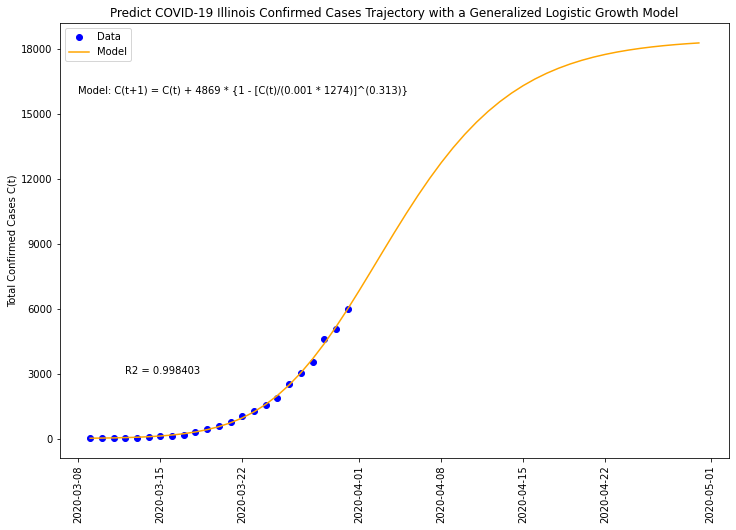

In [13]:
fig = plt.figure(figsize = (12, 8))
plt.title('Predict COVID-19 Illinois Confirmed Cases Trajectory with a Generalized Logistic Growth Model')
ax = fig.add_subplot(1, 1, 1)

ax.plot(date_hist, trend_hist, 'bo',label = 'Data')
ax.plot(date_fit, trend_fit, label = 'Model', color = 'orange')
ax.set_yticks(range(0, 21000, 3000))
ax.set_ylabel('Total Confirmed Cases C(t)')
ax.legend(loc = 'best')
ax.text(np.datetime64('2020-03-12'), 3000, "R2 = %f"%r2)
ax.text(np.datetime64('2020-03-08'), 16000, "Model: C(t+1) = C(t) + 4869 * {1 - [C(t)/(0.001 * 1274)]^(0.313)}")

plt.xticks(rotation = 90)